<a href="https://colab.research.google.com/github/rlsn/COPD_Classification/blob/main/nodule_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.4 MB/s eta 0:00:00


In [63]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
datadir="datasets/luna16"

In [ ]:
# download dataset
!mkdir -p $datadir
!wget -O $datadir/annotations.csv https://zenodo.org/records/3723295/files/annotations.csv?download=1
for i in range(7):
    !wget -O $datadir/subset$i.zip https://zenodo.org/records/3723295/files/subset$i.zip?download=1
    !unzip $datadir/subset$i.zip -d $datadir
for i in range(7,10):
    !wget -O $datadir/subset$i.zip https://zenodo.org/records/4121926/files/subset$i.zip?download=1
    !unzip $datadir/subset$i.zip -d $datadir

In [4]:

def read_image(image_file):
    # Read the MetaImage file
    image = sitk.ReadImage(image_file, imageIO="MetaImageIO")
    image_array = sitk.GetArrayFromImage(image)

    # print the image's dimensions
    return image_array, np.array(image.GetOrigin()), np.array(image.GetSpacing())

# read_image("datasets/luna16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd")

In [5]:
def read_csv(fn):
    with open(fn,"r") as f:
        lines = [l.strip().split(",") for l in f.readlines()]
    return lines


annotations = read_csv("datasets/luna16/annotations.csv")[1:]

In [18]:
import glob, os
def survey_dataset(datadir="."):
    data_split = dict()
    for i in range(10):
        files = glob.glob(f"{datadir}/subset{i}/*mhd")
        data_split[i]=files
    return data_split

data_split = survey_dataset()
D=[]
for i,a in enumerate(annotations):
    if a[0] in data_split[0]:
        D.append((i,a))

In [66]:
def add_marker(img, loc, size=20):
    mark = np.zeros_like(img)
    new_img = np.copy(img)
    x,y = int(loc[0]),int(loc[1])
    value = img.max() if new_img[x,y]<(img.max()-img.min())/2 else img.min()
    new_img[x-size:x+size,y-size]=value
    new_img[x-size:x+size,y+size]=value
    new_img[x-size,y-size:y+size]=value
    new_img[x+size,y-size:y+size]=value
    return new_img

def convert_loc(coord, origin, space):
    displacement = np.array(coord[:3]).astype(float)-origin
    loc = (displacement/space).astype(int)[::-1]
    return loc

def mark_location(img, coord, origin, space):
    loc = convert_loc(coord, origin, space)
    return add_marker(img[loc[0]],loc[1:])

def export_as_gif(filename, image_array, frames_per_second=20, rubber_band=False):
    images = []
    image_array = (image_array-image_array.min())/(image_array.max()-image_array.min())
    for arr in image_array:
        im = Image.fromarray(np.uint8(arr*255))
        images.append(im)
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

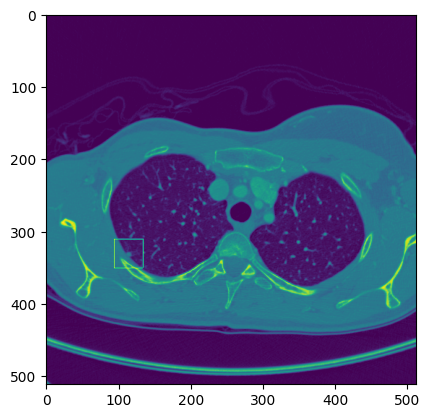

In [89]:
from torch.utils.data import Dataset

def getUID(filename):
    return os.path.basename(filename)[:-4]

def random_crop_3D(img, crop_size):
    size = np.array(img.shape)
    high = size-crop_size
    start = [np.random.randint(0, high=high[0]),
           np.random.randint(0, high=high[1]),
           np.random.randint(0, high=high[2])]
    return img[start[0]:start[0]+crop_size[0],
               start[1]:start[1]+crop_size[1],
               start[2]:start[2]+crop_size[2]]

def random_crop_around_3D(img, loc, crop_size, margin=[5,20,20]):
    size = np.array(img.shape)
    margin = np.array(margin)
    low = loc+margin-crop_size
    high = loc-margin
    start = [np.random.randint(low[0], high=high[0]),
           np.random.randint(low[1], high=high[1]),
           np.random.randint(low[2], high=high[2])]
    return img[start[0]:start[0]+crop_size[0],
               start[1]:start[1]+crop_size[1],
               start[2]:start[2]+crop_size[2]]

def random_flip(img, axis):
    if np.random.rand()<0.5:
        return np.flip(img, axis=axis)
    else:
        return img

class LUNA16_Dataset(Dataset):
    """
    https://luna16.grand-challenge.org/
    """
    def __init__(self, split=None, data_dir=".", crop_size=[40,128,128]):
        annotations_csv = read_csv(f"{data_dir}/annotations.csv")[1:]
        data_subsets = survey_dataset(data_dir)
        # to filenames
        if split is None:
            split = np.arange(10) # all subsets
        self.filenames = []
        for s in split:
            self.filenames+=data_subsets[s]
        # annotation to dict
        self.annotations = dict([(getUID(k),[]) for k in self.filenames])
        for entry in annotations_csv:
            self.annotations.setdefault(entry[0], [])
            self.annotations[entry[0]]+=[entry[1:]]

        self.crop_size = np.array(crop_size)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fn = self.filenames[idx]
        uid = getUID(fn)
        image, origin, space = read_image(fn)
        coords = self.annotations[uid]

        result = dict()
        if len(coords)>0 and np.random.rand()<0.5:
            # crop with a nodule
            target_idx = np.random.randint(len(coords))
            coord = coords[target_idx]
            loc = convert_loc(coord, origin, space)
            cropped_img = random_crop_around_3D(image, loc, self.crop_size)

            # for debugging
            mark_im = mark_location(image, coords[target_idx], origin, space)
            result["marked_img"]=mark_im

        else:
            # random crop
            cropped_img = random_crop_3D(image, self.crop_size)

        # random flip
        cropped_img = random_flip(cropped_img, 0)
        cropped_img = random_flip(cropped_img, 1)
        cropped_img = random_flip(cropped_img, 2)

        result["pixel_values"]=cropped_img
        return result


dataset = LUNA16_Dataset(data_dir=datadir)
re = dataset[64]
image = re["pixel_values"]
export_as_gif("ct.gif",image)
if "marked_img" in re:
    plt.imshow(re["marked_img"])

In [54]:
np.array([40,128,128])/np.array([4,16,16])

array([10.,  8.,  8.])